<a href="https://colab.research.google.com/github/papasanimohansrinivas/MarathiHandLetterRecognition/blob/master/MarathiLetterRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !git clone https://github.com/papasanimohansrinivas/MarathiHandLetterRecognition.git
# !pip install cv2

In [0]:
from google.colab import files
from matplotlib import pyplot as plt
import PIL.Image as Image
from cv2 import imread,imshow
import numpy as np
import cv2

In [0]:
dd=files.upload()

Saving Assignment.jpg to Assignment.jpg


In [0]:
ls

Assignment.jpg  sample_data/


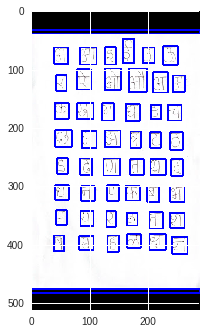

In [79]:
MIN_CONTOUR_AREA = 100

img = cv2.imread("./Assignment.jpg")  

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

# plt.imshow(gray)
blured = cv2.blur(gray, (7,7), 0)    

img_thresh = cv2.adaptiveThreshold(blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))

threshed = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, rect_kernel)
imgContours, Contours, Hierarchy = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ci=0
for contour in Contours:
    if cv2.contourArea(contour) > MIN_CONTOUR_AREA:
        [X, Y, W, H] = cv2.boundingRect(contour)
        cv2.rectangle(img, (X, Y), (X + W, Y + H), (0,0,255), 2) ###
        roi_ = img[Y:Y+H, X:X+W]
        cv2.imwrite('{}.bmp'.format(ci), roi_)
        ci+=1
        
plt.imshow(img)
ss=Image.fromarray(img)
ss.save("contoured.bmp")

In [85]:
ls

10.bmp  16.bmp  21.bmp  27.bmp  32.bmp  38.bmp  43.bmp  4.bmp  Assignment.jpg
11.bmp  17.bmp  22.bmp  28.bmp  33.bmp  39.bmp  44.bmp  5.bmp  contoured.bmp
12.bmp  18.bmp  23.bmp  29.bmp  34.bmp  3.bmp   45.bmp  6.bmp  marathi/
13.bmp  19.bmp  24.bmp  2.bmp   35.bmp  40.bmp  46.bmp  7.bmp  omniglot/
14.bmp  1.bmp   25.bmp  30.bmp  36.bmp  41.bmp  47.bmp  8.bmp  re5.zip
15.bmp  20.bmp  26.bmp  31.bmp  37.bmp  42.bmp  48.bmp  9.bmp  sample_data/


In [77]:
rm -rf marathi/ ; rm {0..49}.bmp

rm: cannot remove '0.bmp': No such file or directory
rm: cannot remove '49.bmp': No such file or directory


In [80]:
%%script bash
rm 0.bmp 49.bmp
mkdir ./marathi/ 

mkdir ./marathi/testing 
mkdir ./marathi/training
for y in {1..48}
do
    mkdir "./marathi/training/letter$y"
    mkdir "./marathi/testing/letter$y"
    cp "$y.bmp" "./marathi/training/letter$y"
    cp "$y.bmp" "./marathi/testing/letter$y"
    ls "./marathi/training/letter$y"
done

1.bmp
2.bmp
3.bmp
4.bmp
5.bmp
6.bmp
7.bmp
8.bmp
9.bmp
10.bmp
11.bmp
12.bmp
13.bmp
14.bmp
15.bmp
16.bmp
17.bmp
18.bmp
19.bmp
20.bmp
21.bmp
22.bmp
23.bmp
24.bmp
25.bmp
26.bmp
27.bmp
28.bmp
29.bmp
30.bmp
31.bmp
32.bmp
33.bmp
34.bmp
35.bmp
36.bmp
37.bmp
38.bmp
39.bmp
40.bmp
41.bmp
42.bmp
43.bmp
44.bmp
45.bmp
46.bmp
47.bmp
48.bmp


In [0]:
# ls ./marathi/training/letter1/

In [0]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
class Config():
    training_dir = "/content/marathi/training/"
    testing_dir = "/content/marathi/testing/"
    train_batch_size = 12
    train_number_epochs = 400

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [0]:
# folder_dataset.imgs

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([
                                                                        transforms.Resize((100,100)),
                                                                      transforms.ToTensor(),
#                                                                       transforms.RandomHorizontalFlip(),
#                                                                        transforms.RandomHorizontalFlip()
                                                                      ])
                                       ,should_invert=False)

In [412]:
siamese_dataset.__getitem__(12)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([1.]))

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [417]:
net

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [0]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
%matplotlib inline

Epoch number 0
 Current loss 1.55128276348

Epoch number 0
 Current loss 5.00349283218

Epoch number 0
 Current loss 2.09473347664

Epoch number 1
 Current loss 1.1593580246

Epoch number 1
 Current loss 1.28743851185

Epoch number 1
 Current loss 1.24517381191

Epoch number 2
 Current loss 1.86730062962

Epoch number 2
 Current loss 1.19320881367

Epoch number 2
 Current loss 1.6730247736

Epoch number 3
 Current loss 0.988223195076

Epoch number 3
 Current loss 0.919804036617

Epoch number 3
 Current loss 1.33600497246

Epoch number 4
 Current loss 1.50533378124

Epoch number 4
 Current loss 1.11574935913

Epoch number 4
 Current loss 1.21565794945

Epoch number 5
 Current loss 1.21987688541

Epoch number 5
 Current loss 1.04690611362

Epoch number 5
 Current loss 1.18198859692

Epoch number 6
 Current loss 1.35358870029

Epoch number 6
 Current loss 1.21245598793

Epoch number 6
 Current loss 1.01632344723

Epoch number 7
 Current loss 0.621149122715

Epoch number 7
 Current loss 1.

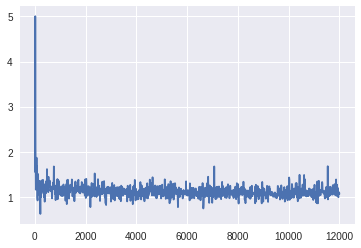

In [421]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
#         print label
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
tst_accuracy = 0

matches = 0
mismatches = 0
total = 0
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
# x0,_,_ = next(dataiter)
while 1:
  try:
    
    x0,x1,label2 = next(dataiter)
#     concatenated = torch.cat((x0,x1),0)
    total+=1
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if  label2.item()==1.0:
      if euclidean_distance>1.5:
        matches+=1
      else:
        mismatches+=1
    else:
      if euclidean_distance<0.5:
        matches+=1
      else:
        mismatches+=1
#     imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
  except StopIteration:
    break

In [456]:
matches/(total+0.0),matches,mismatches,total

(0.3819444444444444, 110, 178, 288)

In [0]:
# iter(test_dataloader).next()

In [0]:
# !zip -r  re5.zip ./marathi/ 

In [0]:
# Image.open("1.bmp")

In [0]:
files.download("re5.zip")

In [86]:
pwd

u'/content'

In [0]:
transform=transforms.Compose([transforms.Resize((300,300)),transforms.RandomCrop(200)])

rot_transforms = []
for angle in [25,45,10,15,50]:
  transform2 = transforms.Compose([transforms.Resize((300,300)),transforms.RandomRotation(angle, resample=PIL.Image.BILINEAR)])
  rot_transforms.append([transform2,angle])
rot_transforms_tst = []
for tstangle in [80,75,6,35]:
  transform3 = transforms.Compose([transforms.Resize((300,300)),transforms.RandomRotation(tstangle, resample=PIL.Image.BILINEAR)])
  rot_transforms_tst.append([transform3,tstangle])
  
# transforms.RandomHorizontalFlip(),transforms.ToTensor(),transforms.RandomVerticalFlip(p=0.99),transforms.RandomCrop(200),transforms.Resize((300,300))

In [0]:
for num in range(1,49):
  a,b,c= np.array(Image.open("./marathi/training/letter{}/{}.bmp".format(num,num))).shape
  
  transform(Image.open("./marathi/training/letter{}/{}.bmp".format(num,num))).save("./marathi/training/letter{}/cropped_{}.bmp".format(num,num))
  
  for pair in rot_transforms:
    rt_transform,rot_angle = pair
    
    rt_transform(Image.open("./marathi/training/letter{}/{}.bmp".format(num,num))).save("./marathi/training/letter{}/{}_rot_{}.bmp".format(num,num,rot_angle))
  
  for pair2 in rot_transforms_tst:
    rt_transform_tst,tst_angle = pair2
    rt_transform_tst(Image.open("./marathi/testing/letter{}/{}.bmp".format(num,num))).save("./marathi/testing/letter{}/{}_rot_{}.bmp".format(num,num,tst_angle))   

In [371]:
# cur_img = 24
# np.array(transform2(Image.open("./marathi/training/letter{}/{}.bmp".format(cur_img,cur_img)))).shape

(300, 300, 3)

In [392]:
!zip -r marathi.zip ./marathi/

  adding: marathi/ (stored 0%)
  adding: marathi/training/ (stored 0%)
  adding: marathi/training/letter43/ (stored 0%)
  adding: marathi/training/letter43/43_rot_45.bmp (deflated 78%)
  adding: marathi/training/letter43/43.bmp (deflated 61%)
  adding: marathi/training/letter43/43_rot_50.bmp (deflated 80%)
  adding: marathi/training/letter43/43_rot_15.bmp (deflated 77%)
  adding: marathi/training/letter43/cropped_43.bmp (deflated 86%)
  adding: marathi/training/letter43/43_rot_10.bmp (deflated 79%)
  adding: marathi/training/letter43/43_rot_25.bmp (deflated 77%)
  adding: marathi/training/letter38/ (stored 0%)
  adding: marathi/training/letter38/cropped_38.bmp (deflated 77%)
  adding: marathi/training/letter38/38_rot_15.bmp (deflated 78%)
  adding: marathi/training/letter38/38_rot_25.bmp (deflated 78%)
  adding: marathi/training/letter38/38_rot_10.bmp (deflated 81%)
  adding: marathi/training/letter38/38_rot_50.bmp (deflated 78%)
  adding: marathi/training/letter38/38_rot_45.bmp (defla

In [376]:
ls

10.bmp  16.bmp  21.bmp  27.bmp  32.bmp  38.bmp  43.bmp  4.bmp  Assignment.jpg
11.bmp  17.bmp  22.bmp  28.bmp  33.bmp  39.bmp  44.bmp  5.bmp  contoured.bmp
12.bmp  18.bmp  23.bmp  29.bmp  34.bmp  3.bmp   45.bmp  6.bmp  marathi/
13.bmp  19.bmp  24.bmp  2.bmp   35.bmp  40.bmp  46.bmp  7.bmp  omniglot/
14.bmp  1.bmp   25.bmp  30.bmp  36.bmp  41.bmp  47.bmp  8.bmp  re5.zip
15.bmp  20.bmp  26.bmp  31.bmp  37.bmp  42.bmp  48.bmp  9.bmp  sample_data/


In [0]:
rm marathi.zip

In [0]:
files.download("marathi.zip")